### Imports

In [1]:
import os
import cv2
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove as rembg_remove
from glob import glob

### Config

In [2]:
BASE_DIR = os.path.abspath("../").replace("\\", "/")  # Go one level up from dataset-scripts

LEAF_DIR = f"{BASE_DIR}/assets/dataset_bg_removed/train/Black Rot"
BG_DIR = f"{BASE_DIR}/assets/background_images"
OUT_DIR = f"{BASE_DIR}/assets/dataset_with_bg/train/Black Rot"

print("LEAF_DIR:", LEAF_DIR)
print("BG_DIR:", BG_DIR)
print("OUT_DIR:", OUT_DIR)

NUM_IMAGES = 100
TARGET_WIDTH = 600

LEAF_DIR: C:/Users/adamk/PycharmProjects/bc-grape-disease/assets/dataset_bg_removed/train/Black Rot
BG_DIR: C:/Users/adamk/PycharmProjects/bc-grape-disease/assets/background_images
OUT_DIR: C:/Users/adamk/PycharmProjects/bc-grape-disease/assets/dataset_with_bg/train/Black Rot


### Functions

In [3]:
def resize_with_aspect_ratio(image, target_width):
    h, w = image.shape[:2]
    scale = target_width / w
    target_height = int(h * scale)
    return cv2.resize(image, (target_width, target_height))

In [4]:
def random_affine(image):
    rows, cols = image.shape[:2]
    tx = random.uniform(-0.1, 0.1) * cols
    ty = random.uniform(-0.1, 0.1) * rows
    scale = random.uniform(0.8, 1.2)
    angle = random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, scale)
    M[0, 2] += tx
    M[1, 2] += ty
    return cv2.warpAffine(image, M, (cols, rows))

In [5]:
def random_perspective(image):
    rows, cols = image.shape[:2]
    pts1 = np.float32([[0, 0], [cols-1, 0], [cols-1, rows-1], [0, rows-1]])
    pts2 = np.float32([
        [random.uniform(0, cols*0.2), random.uniform(0, rows*0.2)],
        [random.uniform(cols*0.8, cols), random.uniform(0, rows*0.2)],
        [random.uniform(cols*0.8, cols), random.uniform(rows*0.8, rows)],
        [random.uniform(0, cols*0.2), random.uniform(rows*0.8, rows)]
    ])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(image, M, (cols, rows))

In [6]:
def remove_background(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_bound = np.array([25, 40, 40])
    upper_bound = np.array([90, 255, 255])

    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    kernel = np.ones((3, 3), np.uint8)
    edges_dilated = cv2.dilate(mask, kernel, iterations=2)

    refined_mask = cv2.bitwise_or(mask, edges_dilated)

    result = cv2.bitwise_and(image, image, mask=refined_mask)
    alpha = refined_mask

    b, g, r = cv2.split(result)
    result = cv2.merge((b, g, r, alpha))

    return result

In [7]:
def overlay_image(background, overlay, position, scale=1.0, angle=0):
    overlay = rembg_remove(overlay)

    overlay = random_affine(overlay)
    overlay = random_perspective(overlay)

    h, w = overlay.shape[:2]
    new_w, new_h = int(w * scale), int(h * scale)
    overlay_resized = cv2.resize(overlay, (new_w, new_h))

    center = (new_w // 2, new_h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    overlay_resized = cv2.warpAffine(overlay_resized, M, (new_w, new_h))

    x, y = position
    h_bg, w_bg = background.shape[:2]

    if x + new_w > w_bg or y + new_h > h_bg:
        print(f"Overlay exceeds background dimensions. {x + new_w} > {w_bg} or {y + new_h} > {h_bg}")
        return background

    if overlay_resized.shape[2] == 4:
        alpha = overlay_resized[:, :, 3] / 255.0
        overlay_resized = overlay_resized[:, :, :3]
    else:
        alpha = np.ones((new_h, new_w))

    for c in range(3):
        background[y:y+new_h, x:x+new_w, c] = (
            background[y:y+new_h, x:x+new_w, c] * (1 - alpha) +
            overlay_resized[:, :, c] * alpha
        )

    return background

### Main

Searching for leaf images in: C:/Users/adamk/PycharmProjects/bc-grape-disease/assets/dataset_bg_removed/train/Black Rot/*.png
Files found: []
208
13


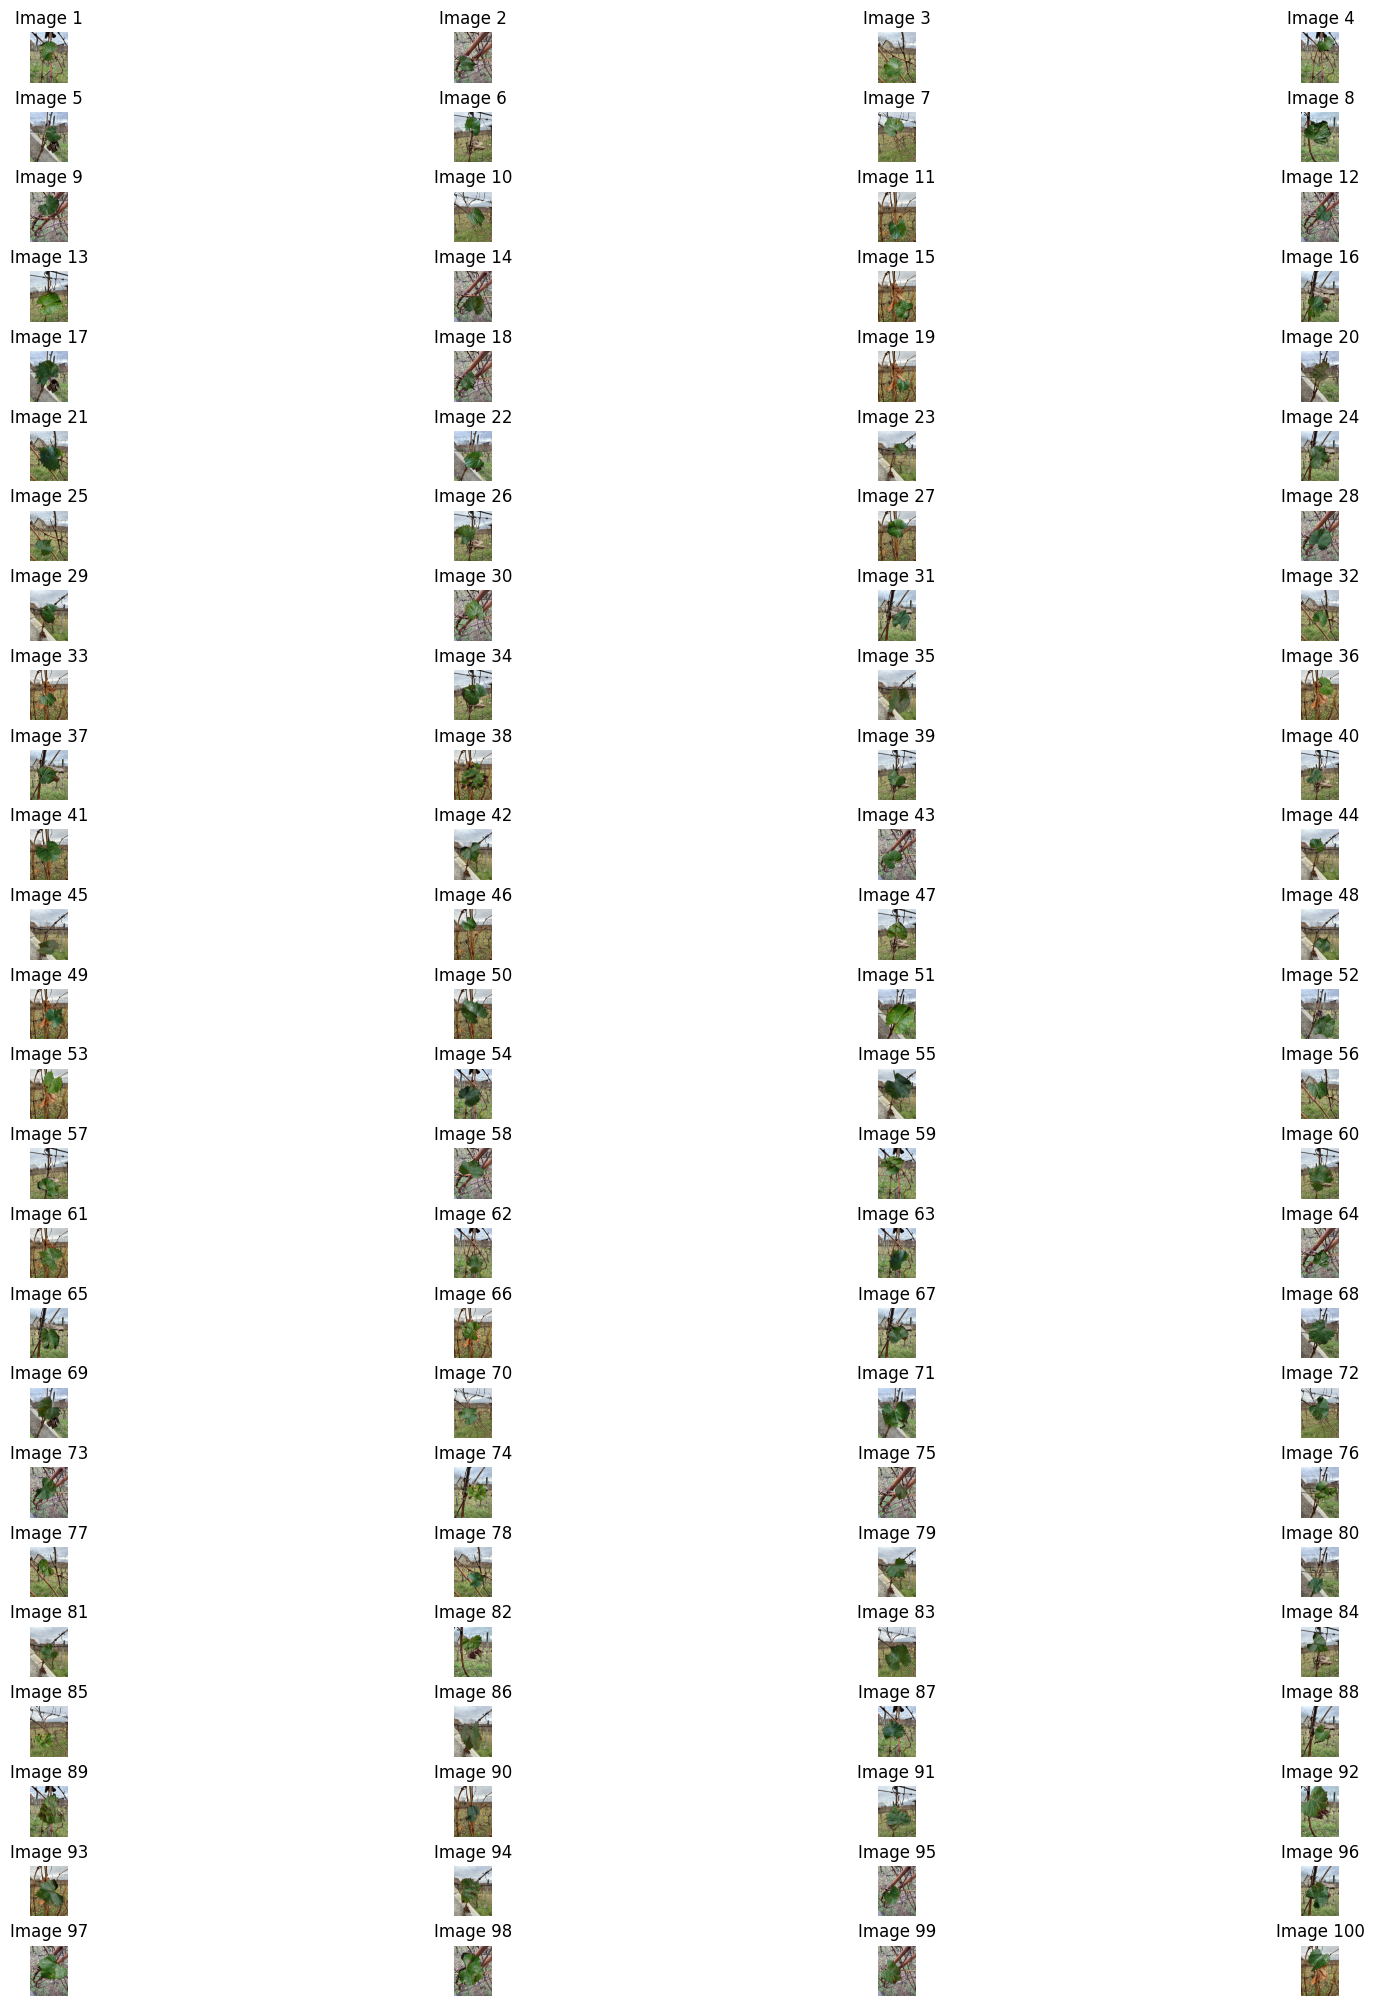

In [11]:
os.makedirs(OUT_DIR, exist_ok=True)

leaf_paths = glob(f"{LEAF_DIR}/*.png") + glob(f"{LEAF_DIR}/*.jpg") + glob(f"{LEAF_DIR}/*.JPG")
bg_paths = glob(f"{BG_DIR}/*.png") + glob(f"{BG_DIR}/*.jpg") + glob(f"{BG_DIR}/*.JPG")

print("Searching for leaf images in:", f"{LEAF_DIR}/*.png")
print("Files found:", glob(f"{LEAF_DIR}/*.png"))

generated_images = []

print(len(leaf_paths))
print(len(bg_paths))

for i in range(NUM_IMAGES):
    bg_path = random.choice(bg_paths)
    bg = cv2.imread(bg_path, cv2.IMREAD_UNCHANGED)
    bg = resize_with_aspect_ratio(bg, TARGET_WIDTH)

    leaf_path = random.choice(leaf_paths)
    leaf = cv2.imread(leaf_path, cv2.IMREAD_UNCHANGED)
    if leaf is None:
        continue

    scale = random.uniform(1.5, 2.25)
    new_w = int(leaf.shape[1] * scale)
    new_h = int(leaf.shape[0] * scale)

    max_x = max(0, bg.shape[1] - new_w)
    max_y = max(0, bg.shape[0] - new_h)
    x = random.randint(0, max_x)
    y = random.randint(0, max_y)
    angle = random.randint(0, 360)

    bg = overlay_image(bg, leaf, (x, y), scale=scale, angle=angle)

    out_path = os.path.join(OUT_DIR, f"generated_{i+1}.png")
    cv2.imwrite(out_path, bg)
    generated_images.append(bg)

plt.figure(figsize=(20, 20))
for idx, img in enumerate(generated_images):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(25, 4, idx + 1)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Image {idx+1}")
plt.tight_layout(pad=0.5)
plt.show()